In [34]:
import pandas as pd
import numpy as np
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

In [35]:
train = pd.read_csv("train_aft.csv")
test = pd.read_csv("test_aft.csv")

train["time_frame"] = train["time_frame"] / 12
test["time_frame"] = test["time_frame"] / 12

y_train = Surv.from_dataframe("GRF_STAT_PA", "time_frame", train)
y_test = Surv.from_dataframe("GRF_STAT_PA", "time_frame", test)

X_train = train.drop(columns=["GRF_STAT_PA", "time_frame"], axis=1)
X_test = test.drop(columns=["GRF_STAT_PA", "time_frame"], axis=1)

In [36]:
rsf = RandomSurvivalForest(n_estimators=150, max_depth=8, max_features="sqrt", min_samples_leaf=3, min_samples_split=3, bootstrap=True, verbose=1, n_jobs=-1, random_state=42)

In [37]:
weights = np.where(y_train["GRF_STAT_PA"] == 1, 3.0, 1.0)  # Event: 2x weight, Censored: 1x weight

In [38]:
rsf.fit(X_train, y_train, sample_weight=weights)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


RandomSurvivalForest(max_depth=8, min_samples_split=3, n_estimators=150,
                     n_jobs=-1, random_state=42, verbose=1)

In [39]:
rsf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   19.5s finished


0.6715447497220479

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   12.9s finished


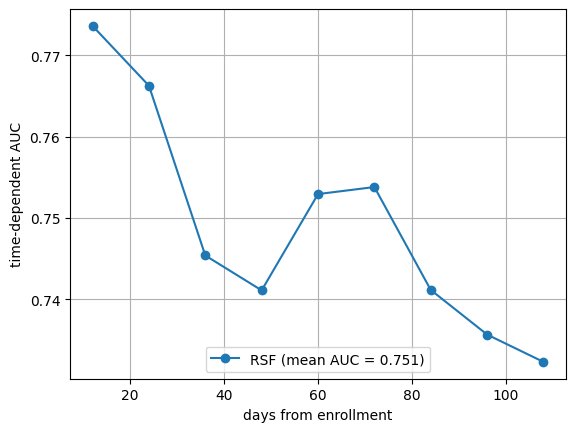

In [40]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc



y_train = pd.DataFrame(y_train, columns=["GRF_STAT_PA", "time_frame"])
y_test = pd.DataFrame(y_test, columns=["GRF_STAT_PA", "time_frame"])

y_train["GRF_STAT_PA"] = y_train["GRF_STAT_PA"].astype("bool")
y_test["GRF_STAT_PA"] = y_test["GRF_STAT_PA"].astype("bool")

# Prepare survival objects for train and test data
y_test_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_test)
y_train_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_train)


times = np.arange(12, 12*10, 12)

rsf_scores = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_surv = np.vstack([chf(times) for chf in rsf_scores])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_surv, times)


plt.plot(times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)




In [41]:
from sksurv.metrics import integrated_brier_score, brier_score
import numpy as np

# Define the time points at which to compute the Brier score
surv_funcs = rsf.predict_survival_function(X_test)

times_2 = np.arange(12, 12*10, 12)

# Convert survival functions into probabilities at specific time points
preds_ibs = np.asarray([[fn(t) for t in times_2] for fn in surv_funcs])


# Compute Brier Score at specific times
brier_scores = brier_score(y_train_surv, y_test_surv, preds_ibs, times_2)
print(f"Brier Scores: {brier_scores}")

# Compute the Integrated Brier Score (IBS) over the specified time points
ibs = integrated_brier_score(y_train_surv, y_test_surv, preds_ibs, times_2)
print(f"Integrated Brier Score (IBS): {ibs}")


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   12.8s finished


Brier Scores: (array([ 12,  24,  36,  48,  60,  72,  84,  96, 108]), array([0.01896221, 0.02724805, 0.04105326, 0.04883387, 0.05543968,
       0.06361072, 0.07152936, 0.0850987 , 0.0903295 ]))
Integrated Brier Score (IBS): 0.05593243703724928
